In [1]:
import os
import zarr
from glob import glob

import numpy as np
import xarray as xr
import pandas as pd

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
fn_area = '/glade/derecho/scratch/ksha/DWC_data/CONUS_domain_GP/static/C404_GP_grid_area.zarr'
ds_area = xr.open_zarr(fn_area)
area_da = ds_area['c404_area']

In [4]:
varname_verif = [
    'WRF_T', 'WRF_U', 'WRF_V', 'WRF_Q_tot', 
    'WRF_T2', 'WRF_TD2', 'WRF_U10', 'WRF_V10',
    'WRF_PWAT', 'WRF_precip', 'WRF_SP'
]

In [5]:
for year in range(2021, 2025):
    for exp_name in ['B3H', 'B6H', 'GDAS']:
        
        fn_pred = f'/glade/campaign/ral/hap/ksha/GWC_results/FINAL_run/final_{exp_name}_{year}_WY.zarr'
        ds_pred = xr.open_zarr(fn_pred)
        ds_pred = ds_pred[varname_verif]
        ds_mean_pred = ds_pred.weighted(area_da).mean(dim=("south_north", "west_east"), skipna=True)
        ds_mean_pred = ds_mean_pred.chunk({'time': 12, 'bottom_top': 12})
        save_name = f'/glade/campaign/ral/hap/ksha/GWC_results/clim/area_weighted_mean_{exp_name}_{year}.zarr'
        ds_mean_pred.to_zarr(save_name, mode='w', consolidated=True, compute=True)
        print(save_name)
        
    fn_true = f'/glade/campaign/ral/hap/ksha/GWC_results/FINAL_run/target_{year}_WY.zarr'
    ds_true = xr.open_zarr(fn_true)
    ds_true = ds_true[varname_verif]
    ds_mean_true = ds_true.weighted(area_da).mean(dim=("south_north", "west_east"), skipna=True)
    ds_mean_true = ds_mean_true.chunk({'time': 12, 'bottom_top': 12})
    save_name = f'/glade/campaign/ral/hap/ksha/GWC_results/clim/area_weighted_mean_target_{year}.zarr'
    ds_mean_true.to_zarr(save_name, mode='w', consolidated=True, compute=True)
    print(save_name)

/glade/campaign/ral/hap/ksha/GWC_results/clim/area_weighted_mean_GDAS_2021.zarr
/glade/campaign/ral/hap/ksha/GWC_results/clim/area_weighted_mean_GDAS_2022.zarr
/glade/campaign/ral/hap/ksha/GWC_results/clim/area_weighted_mean_GDAS_2023.zarr
/glade/campaign/ral/hap/ksha/GWC_results/clim/area_weighted_mean_GDAS_2024.zarr


## Diurnal cycle

In [6]:
def diurnal_cycle_stats(
    rmse_ds,
    time_dim,
    tz = None,
    q = (0.10, 0.90),
) -> xr.Dataset:
    """
    Compute diurnal (hour-of-day) stats for each numeric var in rmse_ds that has `time_dim`.
    Returns a Dataset with dims:
      - hour: 0..23
      - stat: ["mean", "std", "pXX", ...] (one entry per requested quantile)
    Other, non-time dims are preserved (e.g., vertical levels).

    Parameters
    ----------
    rmse_ds : xr.Dataset
        Hourly dataset with a time dimension (default name "Time").
    time_dim : str
        Name of the time dimension.
    tz : str | None
        If provided, convert times to this timezone before grouping by hour.
        If None, use the dataset's time as-is (often UTC).
    q : float or sequence of floats in [0, 1]
        Quantiles to compute (e.g., 0.10, 0.90). Order is preserved.
    """
    # Keep only numeric variables that depend on time
    ds = rmse_ds[[v for v, da in rmse_ds.data_vars.items()
                  if np.issubdtype(da.dtype, np.number) and (time_dim in da.dims)]]

    if ds.sizes.get(time_dim, 0) == 0:
        raise ValueError(f"No data along time dim '{time_dim}' to compute diurnal stats.")

    # Prepare time coordinate (optionally convert to local time)
    t = ds[time_dim]
    if tz is not None:
        # If naive, localize to UTC then convert; if tz-aware, just convert
        try:
            t_local = t.dt.tz_localize("UTC").dt.tz_convert(tz)
        except Exception:
            t_local = t.dt.tz_convert(tz)
    else:
        t_local = t
    
    # Group by hour-of-day
    gb = ds.groupby(t_local.dt.hour)
    
    # Mean and std over time
    mean_hour = gb.mean(dim=time_dim, skipna=True)
    std_hour  = gb.std(dim=time_dim, skipna=True)
    
    # Normalize/validate quantiles
    q_arr = np.atleast_1d(q).astype(float)
    if np.any((q_arr < 0) | (q_arr > 1)):
        raise ValueError("All quantiles in `q` must be within [0, 1].")

    # Compute quantiles (Dataset with 'quantile' dim)
    try:
        q_hour = gb.quantile(q=xr.DataArray(q_arr, dims="quantile"),
                             dim=time_dim, skipna=True, method="linear")
    except TypeError:  # xarray<2023.08 uses 'interpolation'
        q_hour = gb.quantile(q=xr.DataArray(q_arr, dims="quantile"),
                             dim=time_dim, skipna=True, interpolation="linear")

    # Build readable labels for the quantiles: e.g., 0.10 -> "p10", 0.025 -> "p2.5"
    def _q_label(qq: float) -> str:
        val = qq * 100.0
        if np.isclose(val, round(val)):      # integer percent
            return f"p{int(round(val))}"
        # otherwise keep one or two decimals, trimming trailing zeros
        s = f"{val:.2f}".rstrip("0").rstrip(".")
        return f"p{s}"

    q_labels = [_q_label(qq) for qq in q_arr]

    # Rename 'quantile' -> 'stat' and attach labels so we can concat with mean/std
    q_part = q_hour.rename({"quantile": "stat"}).assign_coords(stat=q_labels)

    # Put mean/std into a 'stat' dimension too
    mean_std = xr.concat(
        [mean_hour, std_hour],
        dim=xr.IndexVariable("stat", ["mean", "std"])
    )

    # Concatenate along 'stat'
    out = xr.concat([mean_std, q_part], dim="stat")
    out = out.chunk({"stat": -1, "hour": -1})  # ensure uniform chunks
    
    # Ensure hours 0..23 are present/in order even if some are missing
    out = out.reindex(hour=np.arange(24))

    return out

In [7]:
# exp_name = 'B3H'
varname_diurnal = ['WRF_T2', 'WRF_TD2', 'WRF_U10', 'WRF_V10', 'WRF_PWAT', 'WRF_SP', 'WRF_precip']

In [8]:
for exp_name in ['B1H', 'B3H', 'B6H', 'target', 'GDAS']:
    ds_collection = []
    for year in range(2021, 2025):
        clim_ds = xr.open_zarr(f'//glade/campaign/ral/hap/ksha/GWC_results/clim/area_weighted_mean_{exp_name}_{year}.zarr')
        clim_ds = clim_ds.chunk(dict(time=-1))
        ds_collection.append(clim_ds)
        
    ds_CLIM = xr.concat(ds_collection, dim='time')
    ds_diurnal = diurnal_cycle_stats(ds_CLIM, time_dim='time', q=[0.10, 0.90])
    
    save_name = f'/glade/campaign/ral/hap/ksha/GWC_results/clim/area_weighted_mean_{exp_name}_cycle.zarr'
    ds_diurnal.to_zarr(save_name, mode='w', consolidated=True, compute=True)
    print(save_name)

/glade/campaign/ral/hap/ksha/GWC_results/clim/area_weighted_mean_GDAS_cycle.zarr


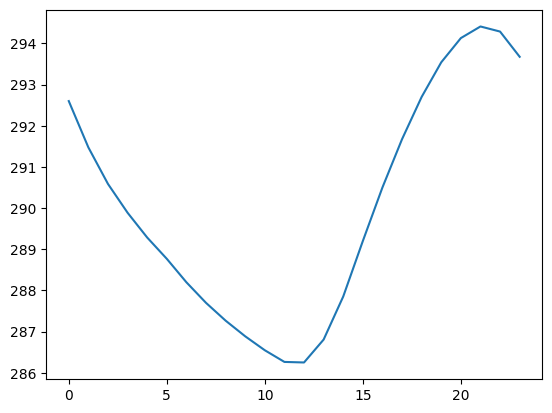

In [9]:
plt.plot(ds_diurnal['WRF_T2'].values[0, :])

## Monthly cycle

In [10]:
def annual_cycle_stats(
    rmse_ds, time_dim,
    tz=None, q=(0.10, 0.90),
):
    """
    Compute monthly (month-of-year) statistics of an hourly Dataset.

    Returns a Dataset with dims:
      - month: 1..12
      - stat: ["mean", "std", "p10", "p90"]  (or more if you pass more quantiles)
    Other, non-time dims are preserved (e.g., bottom_top, south_north, west_east).
    """
    # Keep only numeric vars that depend on time
    ds = rmse_ds[[v for v, da in rmse_ds.data_vars.items()
                  if np.issubdtype(da.dtype, np.number) and (time_dim in da.dims)]]

    if ds.sizes.get(time_dim, 0) == 0:
        raise ValueError(f"No data along time dim '{time_dim}' to compute monthly stats.")

    # Prepare time coordinate (optionally convert to local time)
    t = ds[time_dim]
    if tz is not None:
        # If naive, localize to UTC then convert; if tz-aware, just convert
        try:
            t_local = t.dt.tz_localize("UTC").dt.tz_convert(tz)
        except Exception:
            t_local = t.dt.tz_convert(tz)
    else:
        t_local = t

    # Group by month-of-year
    gb = ds.groupby(t_local.dt.month)

    # Mean & std over time
    mean_m = gb.mean(dim=time_dim, skipna=True)
    std_m  = gb.std(dim=time_dim, skipna=True)

    # Quantiles
    q_arr = np.atleast_1d(q).astype(float)
    if np.any((q_arr < 0) | (q_arr > 1)):
        raise ValueError("All quantiles in `q` must be within [0, 1].")

    try:
        q_m = gb.quantile(q=xr.DataArray(q_arr, dims="quantile"),
                          dim=time_dim, skipna=True, method="linear")
    except TypeError:  # xarray<2023.08 uses 'interpolation'
        q_m = gb.quantile(q=xr.DataArray(q_arr, dims="quantile"),
                          dim=time_dim, skipna=True, interpolation="linear")

    # Build readable labels, e.g. 0.10 -> "p10", 0.025 -> "p2.5"
    def _q_label(qq: float) -> str:
        val = qq * 100.0
        if np.isclose(val, round(val)):
            return f"p{int(round(val))}"
        s = f"{val:.2f}".rstrip("0").rstrip(".")
        return f"p{s}"

    q_labels = [_q_label(qq) for qq in q_arr]

    # Put quantiles under a 'stat' coordinate
    q_part = q_m.rename({"quantile": "stat"}).assign_coords(stat=q_labels)

    # Put mean/std under 'stat' too and concatenate
    mean_std = xr.concat(
        [mean_m, std_m],
        dim=xr.IndexVariable("stat", ["mean", "std"])
    )
    out = xr.concat([mean_std, q_part], dim="stat")

    # Ensure months 1..12 in order (missing months become NaN)
    out = out.reindex(month=np.arange(1, 13))

    # (Optional) make Zarr‑friendly small chunks on the new dims
    out = out.chunk({"stat": -1, "month": -1})

    return out

In [11]:
# exp_name = 'B3H'
varname_diurnal = ['WRF_T2', 'WRF_TD2', 'WRF_U10', 'WRF_V10', 'WRF_PWAT', 'WRF_SP', 'WRF_precip']

for exp_name in ['B1H', 'B3H', 'B6H', 'target', 'GDAS']:
    ds_collection = []
    for year in range(2021, 2025):
        clim_ds = xr.open_zarr(f'//glade/campaign/ral/hap/ksha/GWC_results/clim/area_weighted_mean_{exp_name}_{year}.zarr')
        clim_ds = clim_ds.chunk(dict(time=-1))
        ds_collection.append(clim_ds)
        
    ds_CLIM = xr.concat(ds_collection, dim='time')
    
    ds_month = annual_cycle_stats(ds_CLIM, time_dim='time', q=[0.10, 0.90])
    save_name = f'/glade/campaign/ral/hap/ksha/GWC_results/clim/area_weighted_mean_{exp_name}_annual.zarr'
    ds_month.to_zarr(save_name, mode='w', consolidated=True, compute=True)
    print(save_name)

/glade/campaign/ral/hap/ksha/GWC_results/clim/area_weighted_mean_GDAS_annual.zarr


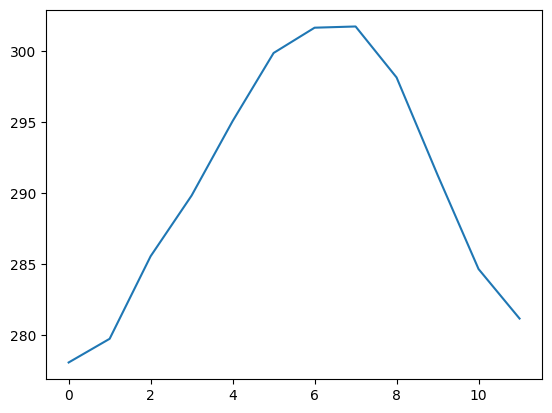

In [19]:
plt.plot(ds_month['WRF_T2'].values[0, :])